<a href="https://colab.research.google.com/github/PengKuang/wasp-assignmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Jingwei Hu, Tianru Zhang, David Vävinggren

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Peng Kuang</font>

- **Team ID:** <font color='red'>LundBooster</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/54581/assignments

**Due Date:** August 22, 2025.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [2]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
import json

# Prepare to save models and metrics
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("metrics", exist_ok=True)

fold_metrics = []

In [32]:
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.5, device=0)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Set max split size to reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [6]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2025-08-05 10:59:18--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0 [following]
--2025-08-05 10:59:18--  https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc7a3191a8dd8eae398ed212470.dl.dropboxusercontent.com/cd/0/inline/Cu36HgV-tRQl406UGr9LCmSCm4HLQJLR-HsIbDpIyXndvdIvbUox7ki5RnA4NOmcIVI_us6SRIjZBrOgMKWDbsnyDGNhqF0VH9j89K-buIydcjpB3RLbkRBhRzN0Dz9pv6I/file# [following]
--2025-08-05 10:59:19--  https://ucc7a3191a8dd8eae398ed212470.dl.dropboxusercontent.com/cd/0

In [7]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [8]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/paulhausner/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 386.28 KiB | 6.44 MiB/s, done.
Resolving deltas: 100% (19/19), done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

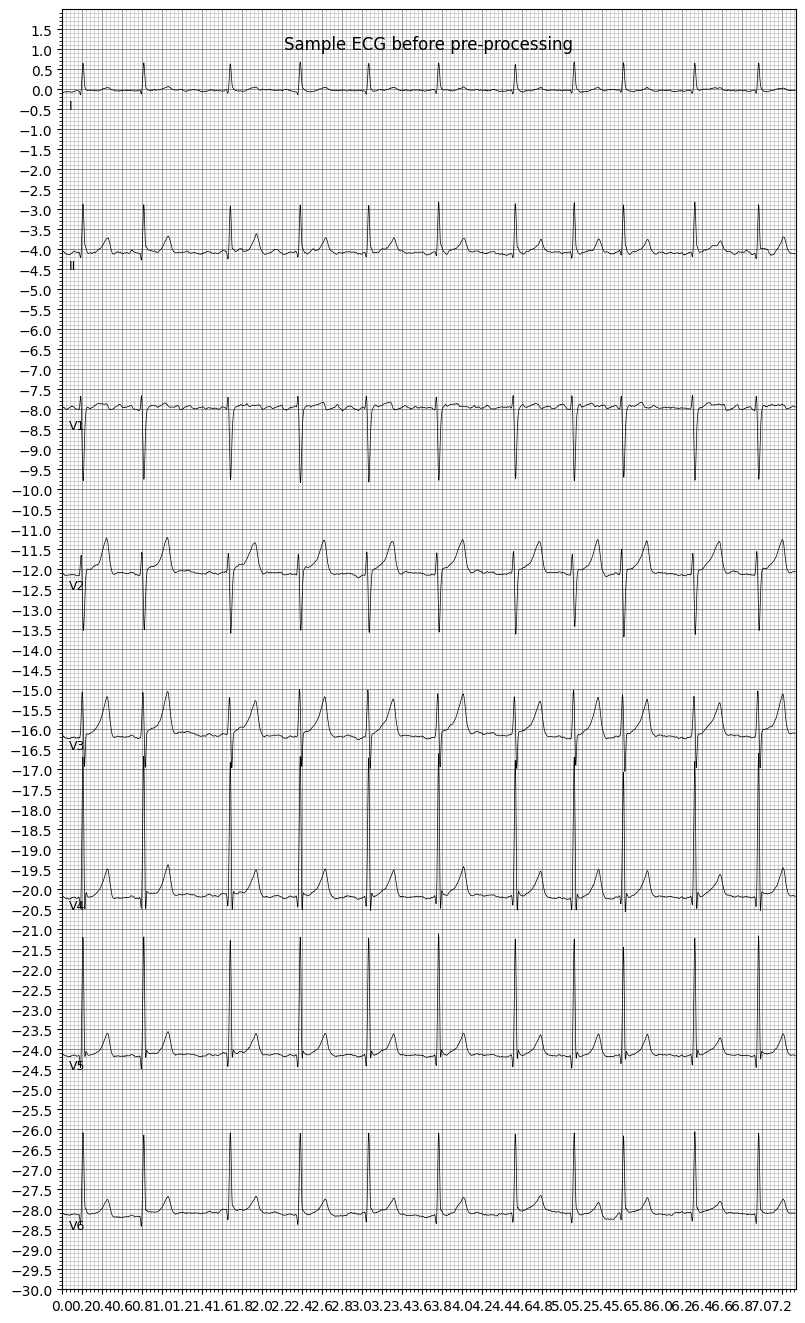

In [9]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

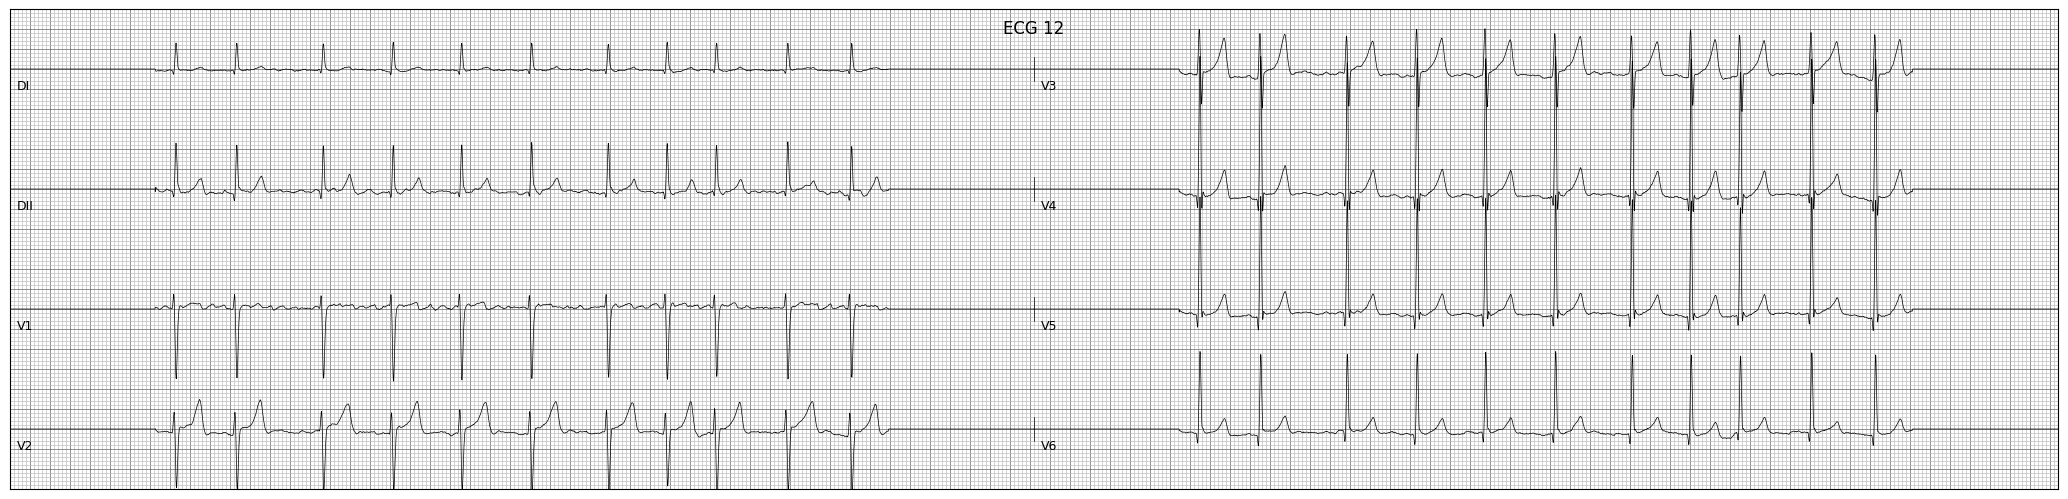

<Figure size 640x480 with 0 Axes>

In [10]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [11]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [00:56<00:00, 178.33it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:38<00:00, 154.72it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


In [12]:
"""
TASK: Insert your code here
"""

import h5py

PATH_TO_H5_FILE_TRAIN = 'codesubset/train.h5'
PATH_TO_H5_FILE_TEST = 'codesubset/test.h5'
f_train = h5py.File(PATH_TO_H5_FILE_TRAIN, 'r')
f_test = h5py.File(PATH_TO_H5_FILE_TEST, 'r')
data = f_train['tracings']

In [15]:
data.shape

(10000, 4096, 8)

In [14]:
data[1].shape

(4096, 8)

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

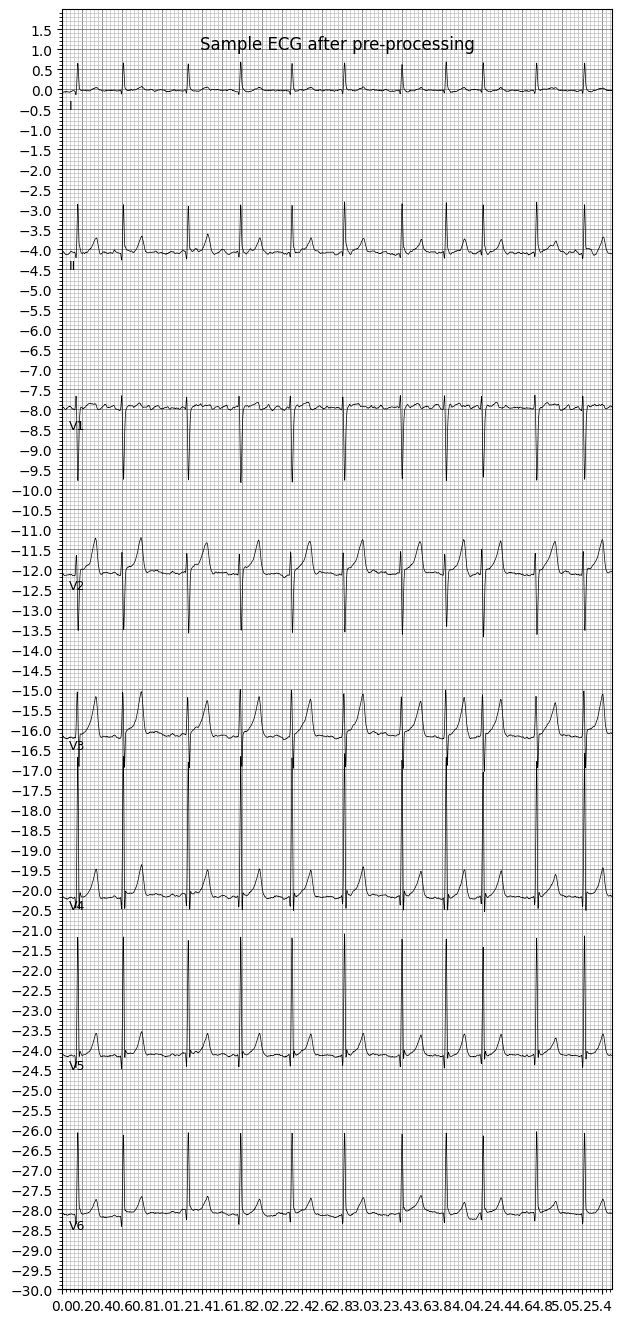

In [13]:
plt.figure()
# lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG after pre-processing')
plt.show()

In [16]:
import h5py
import pandas as pd
import numpy as np

path_to_csv_train_labels = 'codesubset/train.csv'
path_to_records = 'codesubset/train/RECORDS.txt'

# load labels and attributes from the CSV file
df = pd.read_csv(path_to_csv_train_labels)

# Get the order of ids in tracings from the RECORDS.txt file
with open(path_to_records, 'r') as r:
    ids_traces = [int(line.strip().split('TNMG')[1]) for line in r]

# Set 'id_exam' as the index and reindex the DataFrame to match the order of tracings
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces)

In [17]:
df.columns

Index(['id_patient', 'age', 'sex', 'AF', 'date_exam'], dtype='object')

In [18]:
# Access the labels (for Atrial Fibrillation - AF)
labels = np.array(df['AF'])

# Access age and sex
age = np.array(df['age'])
sex = np.array(df['sex'])

# You can now associate these labels and attributes with the corresponding tracings
# For example, to get the label, age, and sex for the first tracing (index 0):
first_tracing_label = labels[0]
first_tracing_age = age[0]
first_tracing_sex = sex[0]

print(f"Label for first tracing: {first_tracing_label}")
print(f"Age for first tracing: {first_tracing_age}")
print(f"Sex for first tracing: {first_tracing_sex}")

Label for first tracing: 1
Age for first tracing: 72
Sex for first tracing: F


In [19]:
# Distribution of patients in the train dataset
print("Distribution of Atrial Fibrillation (AF):")
print(df['AF'].value_counts())
print("\nPercentage distribution of AF:")
print(df['AF'].value_counts(normalize=True) * 100)

Distribution of Atrial Fibrillation (AF):
AF
0    7000
1    3000
Name: count, dtype: int64

Percentage distribution of AF:
AF
0    70.0
1    30.0
Name: proportion, dtype: float64



Descriptive statistics for Age:
count    10000.000000
mean        57.929600
std         17.921952
min         17.000000
25%         45.000000
50%         60.000000
75%         72.000000
max        103.000000
Name: age, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

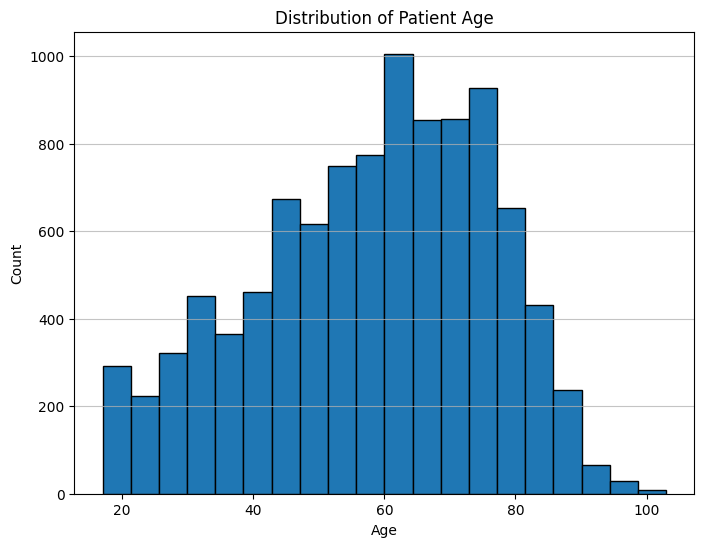

In [20]:
# 2. Examine the distribution of age
print("\nDescriptive statistics for Age:")
print(df['age'].describe())

plt.figure(figsize=(8, 6))
plt.hist(df['age'].dropna(), bins=20, edgecolor='black') # Drop NaN values for plotting
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()


Distribution of Sex:
sex
F    6307
M    3693
Name: count, dtype: int64

Percentage distribution of Sex:
sex
F    63.07
M    36.93
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

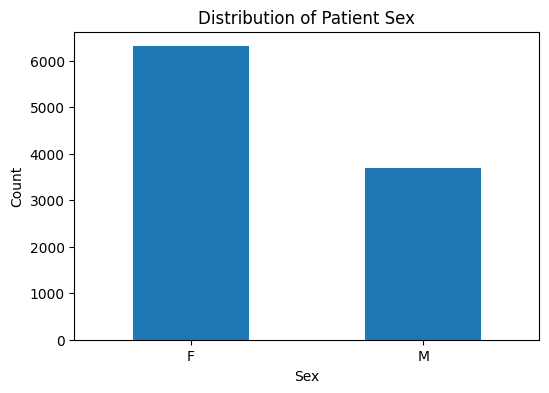

In [21]:
# 3. Examine the distribution of sex
print("\nDistribution of Sex:")
print(df['sex'].value_counts())
print("\nPercentage distribution of Sex:")
print(df['sex'].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
df['sex'].value_counts().plot(kind='bar')
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

The data is not very balanced since 30% of the samples are patients and 70% are healthy people. This is understandable since the scarcity of patient data is common in the field of healthcare. Actually, the absolute number of patient samples in this dataset is not small.

- Age:
  - The age ranges from 17 to 103 yo.
  - The mean age is 57.92 yo, with a standard deviation of 17.92.
  -  50% of are below 60 yo and 75% are below 72 yo.
- Sex: 60% of are female and 40% are male.

The preprocessing is necessary for several reasons:

1. Uniform sample rate makes sure the time intervals across different samples are the same.
2. Some neural netowrk models can only handle sequences with the same length.
2. Removing trends (e.g., baseline wander which is the flat parts of the leads) help preserve only meaningful data for the model to learn.
3. Removing power line noise enhance the data quality and the learning.



---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [22]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [23]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.kernel_size = 3
        self.relu = nn.ReLU()

        # Convolutional layers
        self.conv1 = nn.Conv1d(8, 32, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn4 = nn.BatchNorm1d(256)

        self.conv5 = nn.Conv1d(256, 512, kernel_size=self.kernel_size, stride=2, padding=1)
        self.bn5 = nn.BatchNorm1d(512)

        # Projection layers for residuals (to match dimensions)
        self.res1 = nn.Conv1d(8, 32, kernel_size=1, stride=2)
        self.res2 = nn.Conv1d(32, 64, kernel_size=1, stride=2)
        self.res3 = nn.Conv1d(64, 128, kernel_size=1, stride=2)
        self.res4 = nn.Conv1d(128, 256, kernel_size=1, stride=2)
        self.res5 = nn.Conv1d(256, 512, kernel_size=1, stride=2)

        # Pooling and dropout
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)
        self.dropout5 = nn.Dropout(0.5)

        # Dummy input to calculate flattened size
        dummy_input = torch.randn(1, 4096, 8)
        x = self.forward_features(dummy_input)
        flattened_size = x.view(x.size(0), -1).size(1)

        # Fully connected layer
        self.fc = nn.Linear(flattened_size, 1)

    def forward_features(self, x):
        x = x.transpose(1, 2)

        # Layer 1
        residual = self.res1(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = x + residual
        x = self.pool(x)
        x = self.dropout1(x)

        # Layer 2
        residual = self.res2(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = x + residual
        x = self.pool(x)
        x = self.dropout2(x)

        # Layer 3
        residual = self.res3(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = x + residual
        x = self.pool(x)
        x = self.dropout3(x)

        # Layer 4
        residual = self.res4(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = x + residual
        x = self.pool(x)
        x = self.dropout4(x)

        # Layer 5
        residual = self.res5(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = x + residual
        x = self.pool(x)
        x = self.dropout5(x)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output


In [24]:
from transformers import AutoModel
import torch.nn as nn

class CNNTransformerFusion(nn.Module):
    def __init__(self, cnn_model=None, freeze_transformer=True):
        super().__init__()

        self.cnn = cnn_model if cnn_model is not None else CNNClassifier()

        # Load HuBERT-ECG
        self.transformer = AutoModel.from_pretrained("Edoardo-BS/hubert-ecg-base", trust_remote_code=True)

        if freeze_transformer:
            for param in self.transformer.parameters():
                param.requires_grad = False

        # Sizes: CNN -> 128, Transformer -> transformer.config.hidden_size
        transformer_hidden = self.transformer.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128 + transformer_hidden, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: [B, 8, T]
        cnn_feat = self.cnn(x)  # [B, 128]

        # Pad to 12-lead
        pad = torch.zeros(x.shape[0], 4, x.shape[2], device=x.device)
        x_padded = torch.cat([x, pad], dim=1)

        transformer_out = self.transformer(x_padded).last_hidden_state
        cls_token = transformer_out[:, 0, :]  # [B, hidden_size]

        combined = torch.cat([cnn_feat, cls_token], dim=1)
        return self.classifier(combined)


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=8, d_model=24, nhead=2, num_encoder_layers=2, dim_feedforward=64, dropout=0.1, max_len=5000):
        super(TransformerClassifier, self).__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.max_len = max_len

        # Linear layer to project input features to d_model
        self.input_proj = nn.Linear(input_dim, d_model)

        # Learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

        # Layer normalization and dropout
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Transformer Encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)

        # Attention pooling layer
        self.attention_weights = nn.Linear(d_model, 1)

        # Classification head
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        batch_size, seq_len, _ = x.size()

        # Project input features
        x = self.input_proj(x)

        # Add learnable positional embeddings
        x = x + self.pos_embedding[:, :seq_len, :]

        # Normalize and apply dropout
        x = self.norm(x)
        x = self.dropout(x)

        # Transformer Encoder
        transformer_output = self.transformer_encoder(x)  # (batch_size, seq_len, d_model)

        # Attention pooling
        attn_scores = self.attention_weights(transformer_output)  # (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)           # (batch_size, seq_len, 1)
        pooled_output = torch.sum(attn_weights * transformer_output, dim=1)  # (batch_size, d_model)

        # Classification head
        output = self.classifier(pooled_output)  # (batch_size, 1)

        return output


### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**
I chose the CNN model with multiple convolutional layers because it can better capture complex patterns and longer-term temperal tendancies.

The reason why I chose this autoencoder model is because it is effective at dealing with time series data such as ECG and EEG. I have used this model before for predicting patients and healthy individuals with other similar biometrics. In the essence, it handles an anomarly detection issue.


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [26]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        # Forward pass
        outputs = model(traces)
        # Calculate loss
        loss = loss_function(outputs, diagnoses)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [27]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs = []  # accumulated predicted probabilities
    valid_true = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            # Forward pass
            outputs = model(traces)
            # Calculate loss
            loss = loss_function(outputs, diagnoses)

            # Collect predictions and true labels
            valid_probs.append(torch.sigmoid(outputs).detach().cpu().numpy())
            valid_true.append(diagnoses.detach().cpu().numpy())

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_probs), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**
- I have decreased the learning rate so to have a smoothier curve of gradient descedent to the local optimal
- I have increased the weight_decay to penalize overfitting so the trained model can generalize on new dataset better


In [28]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
# learning_rate = 1e-4
learning_rate = 1e-3
weight_decay = 1e-1
num_epochs = 20
batch_size = 32
# batch_size = 2

In [29]:
# data augumentation
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, traces, labels, augment=False):
        self.traces = traces
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.traces)

    def __getitem__(self, idx):
        x = self.traces[idx]
        y = self.labels[idx]

        if self.augment:
            x = self.apply_augmentations(x)

        return x, y

    def apply_augmentations(self, x):
        # Example: Add Gaussian noise
        noise = torch.randn_like(x) * 0.01
        x = x + noise

        # Example: Random scaling
        scale = torch.empty(1).uniform_(0.9, 1.1).item()
        x = x * scale

        return x

In [30]:
from torch.utils.data import TensorDataset, random_split, DataLoader
from torch.utils.data import WeightedRandomSampler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = ECGDataset(traces, labels, augment=False)
# dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
train_size = int(0.8 * len_dataset)
valid_size = len_dataset - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])

# Enable augmentation only for training
dataset_train.dataset.augment = True

# handle inbalanced classes: add sampler
train_labels_np = np.array([int(dataset_train[i][1].item()) for i in range(len(dataset_train))])
class_sample_counts = np.bincount(train_labels_np)
sample_weights = 1. / class_sample_counts
sample_weights = sample_weights[train_labels_np]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



In [34]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = CNNClassifier()
# model = TransformerClassifier()
# cnn = CNNClassifier()
# model = CNNTransformerFusion(cnn_model=cnn, freeze_transformer=False)
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
# loss_function = nn.BCEWithLogitsLoss()
class_weights_train = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_np), y=train_labels_np)
class_weights_train_tensor = torch.tensor(class_weights_train, dtype=torch.float32).to(device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights_train_tensor[1])

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []
valid_auroc_all, valid_ap_all, valid_f1_all = [], [], [] # Lists to store metrics

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, nn.BCEWithLogitsLoss(), device) # Use standard loss for validation

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """

    # Compute AUROC, AP, and F1
    valid_auroc = roc_auc_score(y_true, y_pred)
    valid_ap = average_precision_score(y_true, y_pred)
    # For F1, we need binary predictions. A common threshold is 0.5 after sigmoid.
    valid_f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

    # Collect metrics
    valid_auroc_all.append(valid_auroc)
    valid_ap_all.append(valid_ap)
    valid_f1_all.append(valid_f1)

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model_hybrid.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
        best_y_true = y_true
        best_y_pred = y_pred
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'Valid AUROC {valid_auroc:.4f} \t'
                'Valid AP {valid_ap:.4f} \t'
                'Valid F1 {valid_f1:.4f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        valid_auroc=valid_auroc,
                        valid_ap=valid_ap,
                        valid_f1=valid_f1,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_all, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss_all, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation metrics for the current fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), valid_auroc_all_fold, label='Valid AUROC')
plt.plot(range(1, num_epochs + 1), valid_ap_all_fold, label='Valid AP')
plt.plot(range(1, num_epochs + 1), valid_f1_all_fold, label='Valid F1')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title(f'Validation Metrics over Epochs (Fold {fold+1})')
plt.legend()
plt.grid(True)
plt.show()

Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB (GPU 0; 14.74 GiB total capacity; 4.21 GiB already allocated; 10.35 GiB free; 7.37 GiB allowed; 4.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

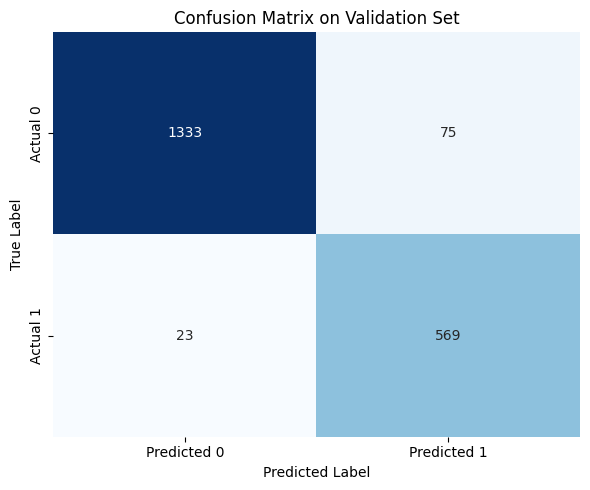

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predicted probabilities to binary predictions
best_y_pred_binary = (best_y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(best_y_true, best_y_pred_binary)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.tight_layout()
plt.show()


Fold 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

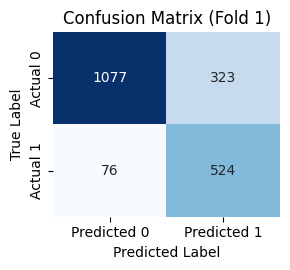

Epoch  1: 	Train Loss 0.022957 	Valid Loss 0.013281 	Valid AUROC 0.9092 	Valid AP 0.8108 	Valid F1 0.7243 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

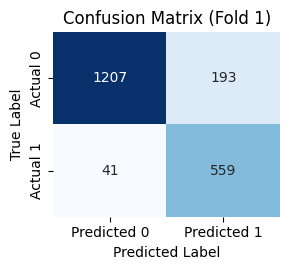

Epoch  2: 	Train Loss 0.014494 	Valid Loss 0.009754 	Valid AUROC 0.9627 	Valid AP 0.9291 	Valid F1 0.8269 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

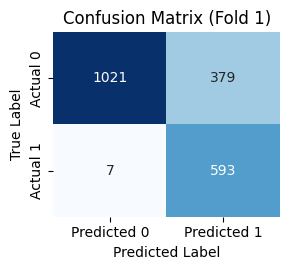

Epoch  3: 	Train Loss 0.011083 	Valid Loss 0.016181 	Valid AUROC 0.9669 	Valid AP 0.9182 	Valid F1 0.7545 	


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

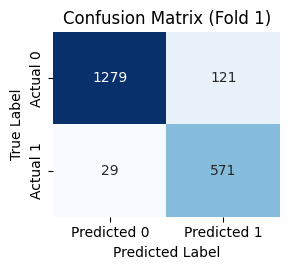

Epoch  4: 	Train Loss 0.009666 	Valid Loss 0.006146 	Valid AUROC 0.9803 	Valid AP 0.9559 	Valid F1 0.8839 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

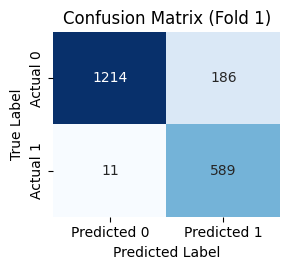

Epoch  5: 	Train Loss 0.008477 	Valid Loss 0.008368 	Valid AUROC 0.9843 	Valid AP 0.9569 	Valid F1 0.8567 	


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

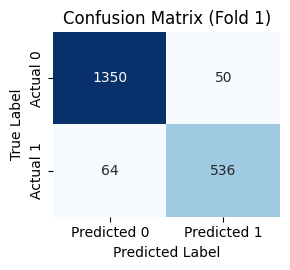

Epoch  6: 	Train Loss 0.008837 	Valid Loss 0.006487 	Valid AUROC 0.9824 	Valid AP 0.9550 	Valid F1 0.9039 	


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

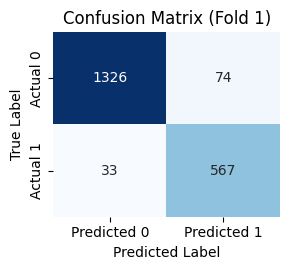

Epoch  7: 	Train Loss 0.008955 	Valid Loss 0.006688 	Valid AUROC 0.9857 	Valid AP 0.9639 	Valid F1 0.9138 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

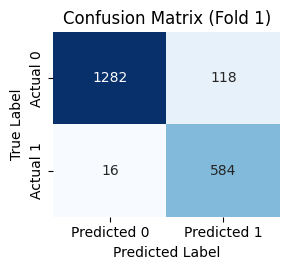

Epoch  8: 	Train Loss 0.009468 	Valid Loss 0.007418 	Valid AUROC 0.9873 	Valid AP 0.9678 	Valid F1 0.8971 	


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

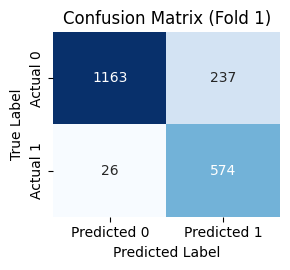

Epoch  9: 	Train Loss 0.009819 	Valid Loss 0.011111 	Valid AUROC 0.9622 	Valid AP 0.9107 	Valid F1 0.8136 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

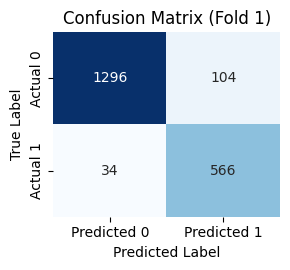

Epoch 10: 	Train Loss 0.009493 	Valid Loss 0.007634 	Valid AUROC 0.9782 	Valid AP 0.9530 	Valid F1 0.8913 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

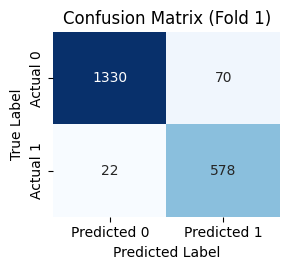

Epoch 11: 	Train Loss 0.008046 	Valid Loss 0.005582 	Valid AUROC 0.9883 	Valid AP 0.9683 	Valid F1 0.9263 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

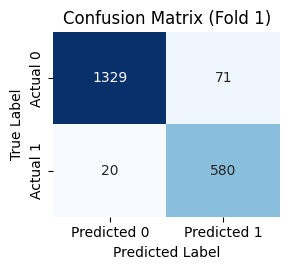

Epoch 12: 	Train Loss 0.007918 	Valid Loss 0.005618 	Valid AUROC 0.9913 	Valid AP 0.9779 	Valid F1 0.9273 	


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

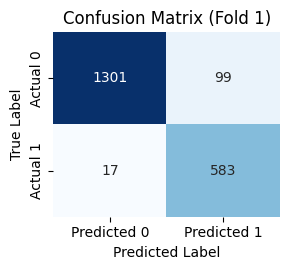

Epoch 13: 	Train Loss 0.007174 	Valid Loss 0.005907 	Valid AUROC 0.9907 	Valid AP 0.9753 	Valid F1 0.9095 	


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

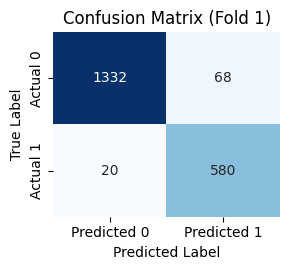

Epoch 14: 	Train Loss 0.006913 	Valid Loss 0.005381 	Valid AUROC 0.9905 	Valid AP 0.9744 	Valid F1 0.9295 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

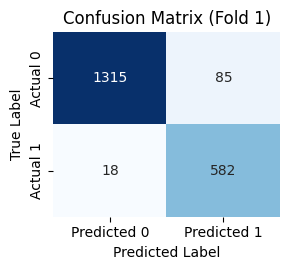

Epoch 15: 	Train Loss 0.007300 	Valid Loss 0.005916 	Valid AUROC 0.9900 	Valid AP 0.9730 	Valid F1 0.9187 	


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

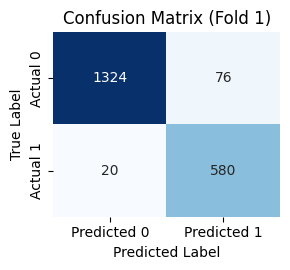

Epoch 16: 	Train Loss 0.007321 	Valid Loss 0.005490 	Valid AUROC 0.9906 	Valid AP 0.9759 	Valid F1 0.9236 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

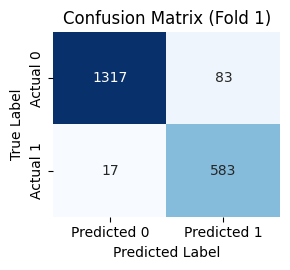

Epoch 17: 	Train Loss 0.007261 	Valid Loss 0.005854 	Valid AUROC 0.9907 	Valid AP 0.9733 	Valid F1 0.9210 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

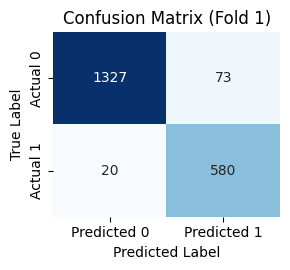

Epoch 18: 	Train Loss 0.006836 	Valid Loss 0.005642 	Valid AUROC 0.9893 	Valid AP 0.9728 	Valid F1 0.9258 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

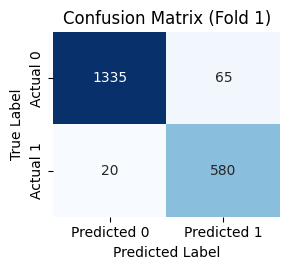

Epoch 19: 	Train Loss 0.007397 	Valid Loss 0.005368 	Valid AUROC 0.9907 	Valid AP 0.9776 	Valid F1 0.9317 	Best model for this fold -> saved


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

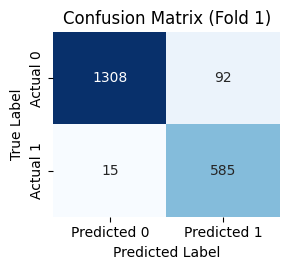

Epoch 20: 	Train Loss 0.007005 	Valid Loss 0.006082 	Valid AUROC 0.9895 	Valid AP 0.9721 	Valid F1 0.9162 	


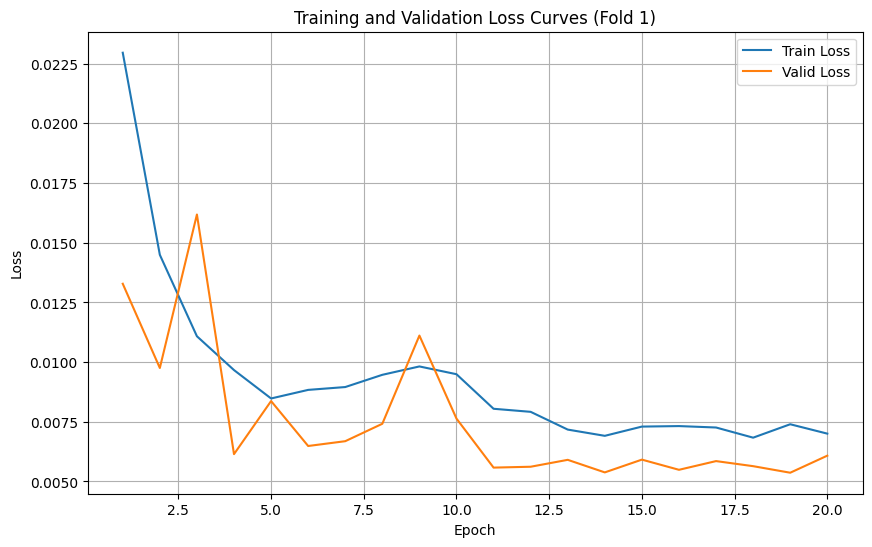

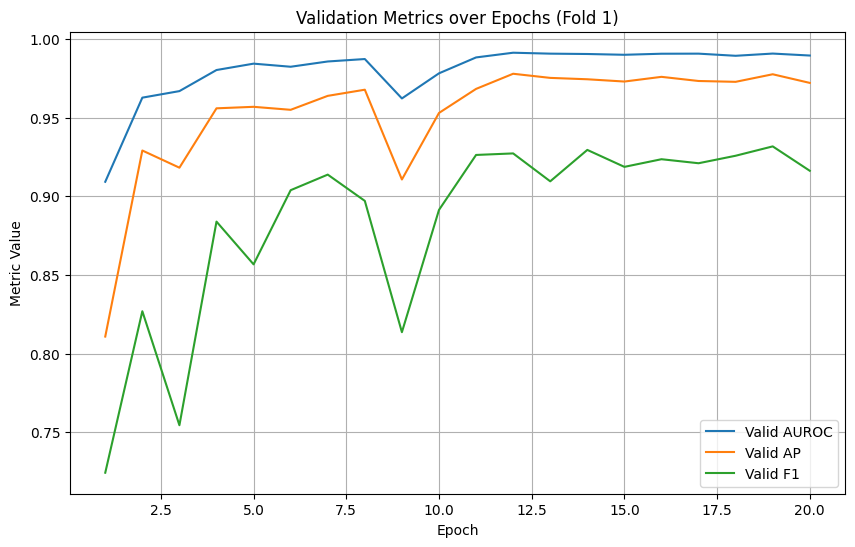


Fold 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

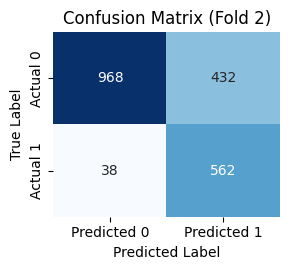

Epoch  1: 	Train Loss 0.023545 	Valid Loss 0.016965 	Valid AUROC 0.9035 	Valid AP 0.7627 	Valid F1 0.7051 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

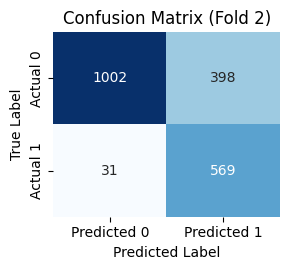

Epoch  2: 	Train Loss 0.013643 	Valid Loss 0.019870 	Valid AUROC 0.9192 	Valid AP 0.7789 	Valid F1 0.7262 	


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

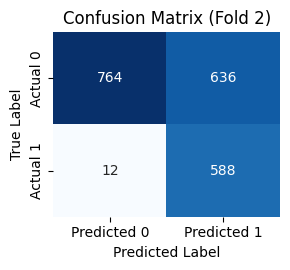

Epoch  3: 	Train Loss 0.011623 	Valid Loss 0.022953 	Valid AUROC 0.9370 	Valid AP 0.8612 	Valid F1 0.6447 	


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

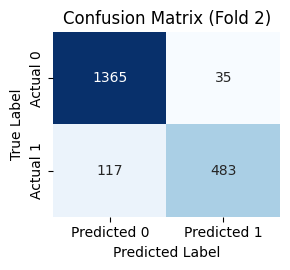

Epoch  4: 	Train Loss 0.009946 	Valid Loss 0.006318 	Valid AUROC 0.9725 	Valid AP 0.9367 	Valid F1 0.8640 	Best model for this fold -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

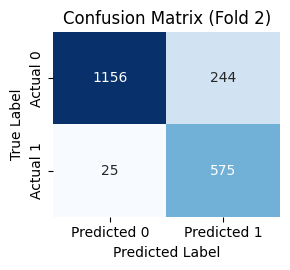

Epoch  5: 	Train Loss 0.009132 	Valid Loss 0.011524 	Valid AUROC 0.9604 	Valid AP 0.8959 	Valid F1 0.8104 	


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

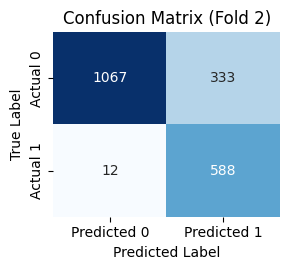

Epoch  6: 	Train Loss 0.008871 	Valid Loss 0.012715 	Valid AUROC 0.9691 	Valid AP 0.9268 	Valid F1 0.7732 	


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

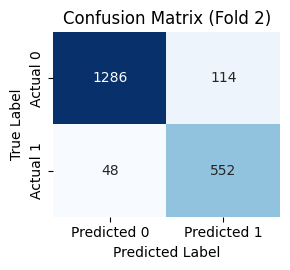

Epoch  7: 	Train Loss 0.009180 	Valid Loss 0.007945 	Valid AUROC 0.9696 	Valid AP 0.9255 	Valid F1 0.8720 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

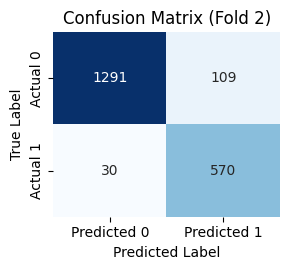

Epoch  8: 	Train Loss 0.009173 	Valid Loss 0.006983 	Valid AUROC 0.9819 	Valid AP 0.9612 	Valid F1 0.8913 	


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

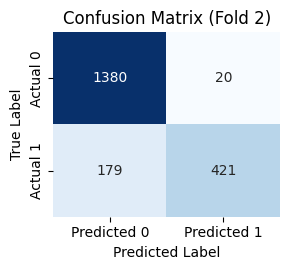

Epoch  9: 	Train Loss 0.009454 	Valid Loss 0.007856 	Valid AUROC 0.9736 	Valid AP 0.9457 	Valid F1 0.8088 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

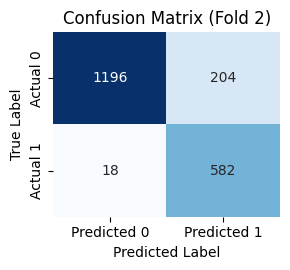

Epoch 10: 	Train Loss 0.009327 	Valid Loss 0.008884 	Valid AUROC 0.9766 	Valid AP 0.9424 	Valid F1 0.8398 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

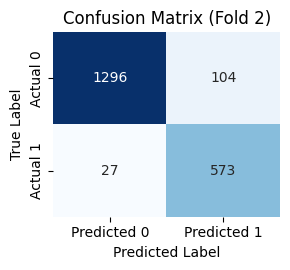

Epoch 11: 	Train Loss 0.007764 	Valid Loss 0.006382 	Valid AUROC 0.9859 	Valid AP 0.9604 	Valid F1 0.8974 	


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

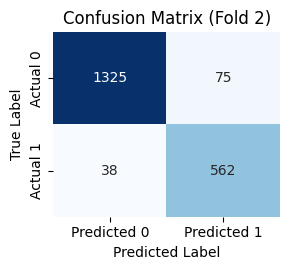

Epoch 12: 	Train Loss 0.007313 	Valid Loss 0.005775 	Valid AUROC 0.9862 	Valid AP 0.9655 	Valid F1 0.9086 	Best model for this fold -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

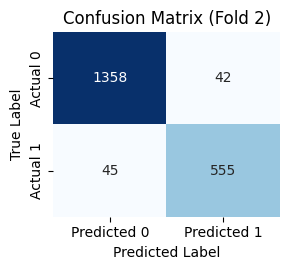

Epoch 13: 	Train Loss 0.006944 	Valid Loss 0.005365 	Valid AUROC 0.9873 	Valid AP 0.9681 	Valid F1 0.9273 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

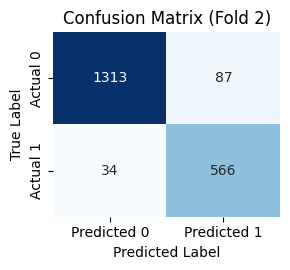

Epoch 14: 	Train Loss 0.007079 	Valid Loss 0.006112 	Valid AUROC 0.9847 	Valid AP 0.9566 	Valid F1 0.9034 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

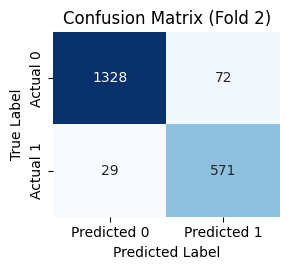

Epoch 15: 	Train Loss 0.006951 	Valid Loss 0.005576 	Valid AUROC 0.9867 	Valid AP 0.9651 	Valid F1 0.9187 	


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

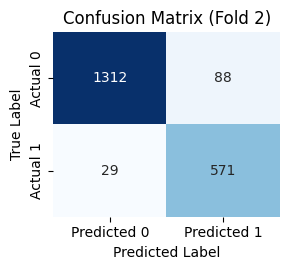

Epoch 16: 	Train Loss 0.007247 	Valid Loss 0.005974 	Valid AUROC 0.9867 	Valid AP 0.9643 	Valid F1 0.9071 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

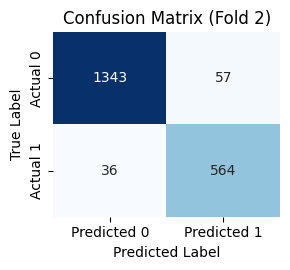

Epoch 17: 	Train Loss 0.007198 	Valid Loss 0.005758 	Valid AUROC 0.9865 	Valid AP 0.9673 	Valid F1 0.9238 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

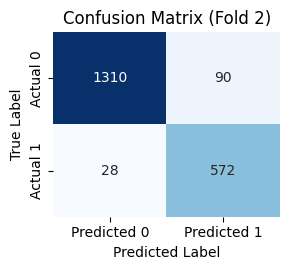

Epoch 18: 	Train Loss 0.006798 	Valid Loss 0.006282 	Valid AUROC 0.9850 	Valid AP 0.9566 	Valid F1 0.9065 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

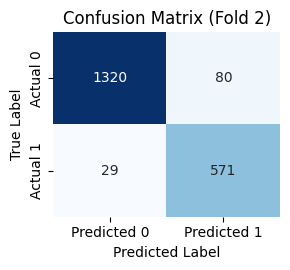

Epoch 19: 	Train Loss 0.006808 	Valid Loss 0.005963 	Valid AUROC 0.9867 	Valid AP 0.9681 	Valid F1 0.9129 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

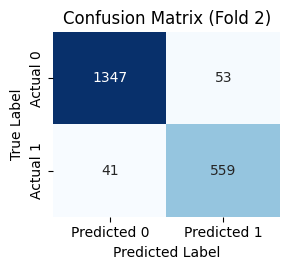

Epoch 20: 	Train Loss 0.006962 	Valid Loss 0.005394 	Valid AUROC 0.9863 	Valid AP 0.9674 	Valid F1 0.9224 	


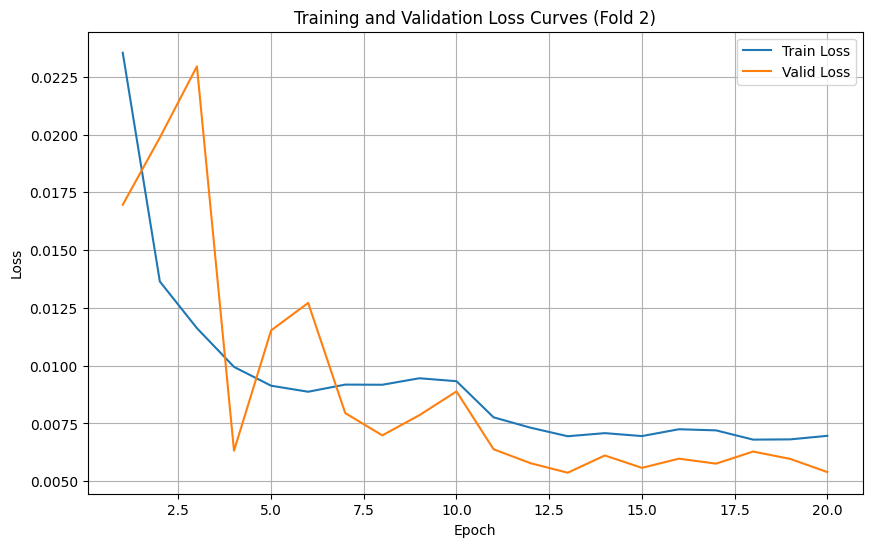

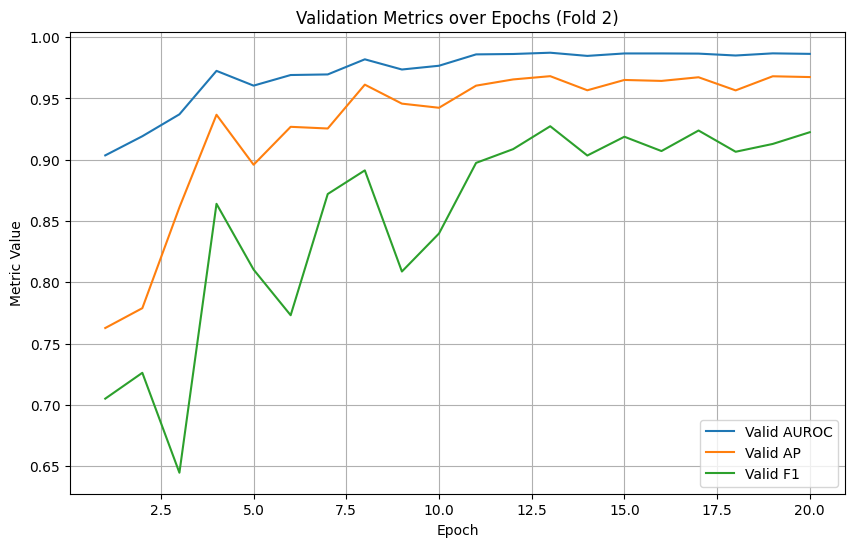


Fold 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

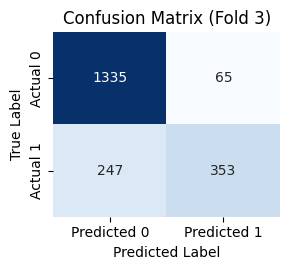

Epoch  1: 	Train Loss 0.023327 	Valid Loss 0.010999 	Valid AUROC 0.9169 	Valid AP 0.8145 	Valid F1 0.6935 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

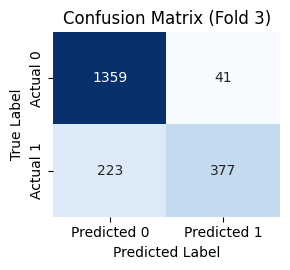

Epoch  2: 	Train Loss 0.014690 	Valid Loss 0.009837 	Valid AUROC 0.9561 	Valid AP 0.8655 	Valid F1 0.7407 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

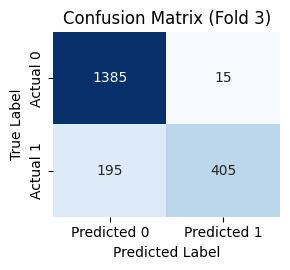

Epoch  3: 	Train Loss 0.010734 	Valid Loss 0.007262 	Valid AUROC 0.9833 	Valid AP 0.9505 	Valid F1 0.7941 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

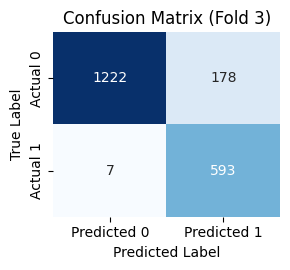

Epoch  4: 	Train Loss 0.008962 	Valid Loss 0.007600 	Valid AUROC 0.9882 	Valid AP 0.9639 	Valid F1 0.8651 	


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

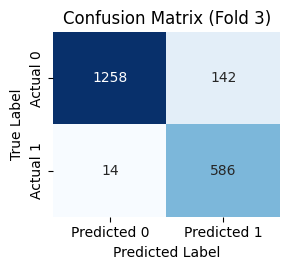

Epoch  5: 	Train Loss 0.008844 	Valid Loss 0.006872 	Valid AUROC 0.9845 	Valid AP 0.9537 	Valid F1 0.8825 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

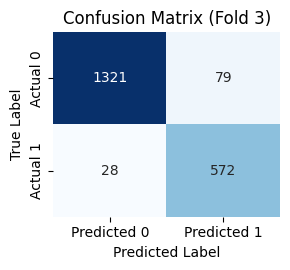

Epoch  6: 	Train Loss 0.008858 	Valid Loss 0.005674 	Valid AUROC 0.9855 	Valid AP 0.9462 	Valid F1 0.9145 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

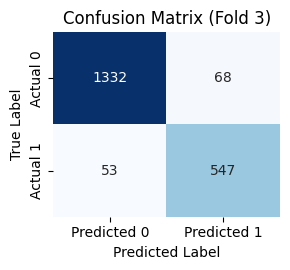

Epoch  7: 	Train Loss 0.009546 	Valid Loss 0.006890 	Valid AUROC 0.9823 	Valid AP 0.9478 	Valid F1 0.9004 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

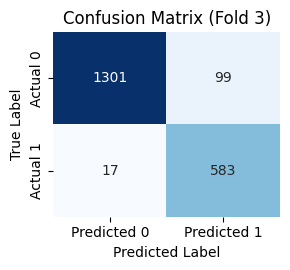

Epoch  8: 	Train Loss 0.008630 	Valid Loss 0.006943 	Valid AUROC 0.9883 	Valid AP 0.9658 	Valid F1 0.9095 	


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

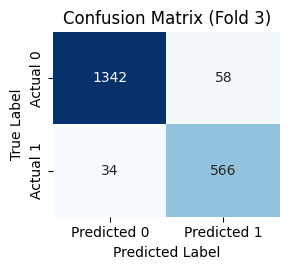

Epoch  9: 	Train Loss 0.010021 	Valid Loss 0.006895 	Valid AUROC 0.9879 	Valid AP 0.9635 	Valid F1 0.9248 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

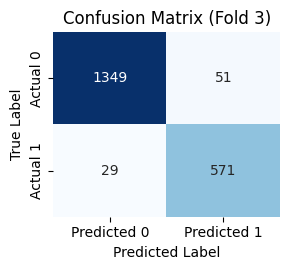

Epoch 10: 	Train Loss 0.009478 	Valid Loss 0.005991 	Valid AUROC 0.9898 	Valid AP 0.9670 	Valid F1 0.9345 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

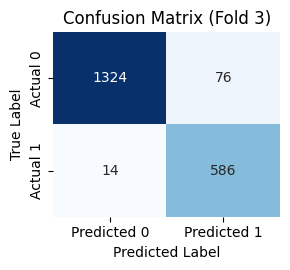

Epoch 11: 	Train Loss 0.007965 	Valid Loss 0.005765 	Valid AUROC 0.9918 	Valid AP 0.9759 	Valid F1 0.9287 	


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

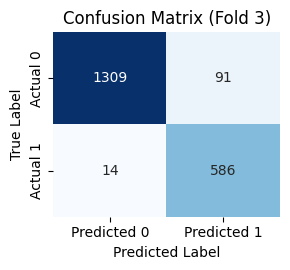

Epoch 12: 	Train Loss 0.007498 	Valid Loss 0.006022 	Valid AUROC 0.9922 	Valid AP 0.9765 	Valid F1 0.9178 	


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

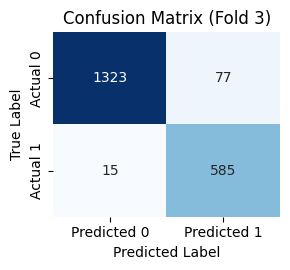

Epoch 13: 	Train Loss 0.007318 	Valid Loss 0.005471 	Valid AUROC 0.9920 	Valid AP 0.9762 	Valid F1 0.9271 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

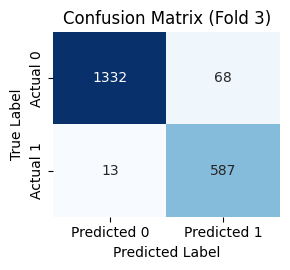

Epoch 14: 	Train Loss 0.007181 	Valid Loss 0.005331 	Valid AUROC 0.9921 	Valid AP 0.9762 	Valid F1 0.9355 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

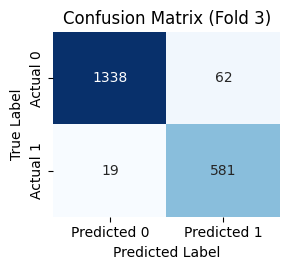

Epoch 15: 	Train Loss 0.007274 	Valid Loss 0.005209 	Valid AUROC 0.9913 	Valid AP 0.9747 	Valid F1 0.9348 	Best model for this fold -> saved


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

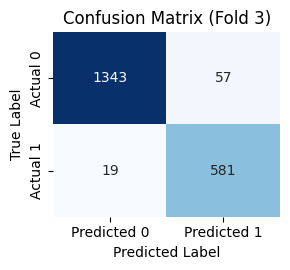

Epoch 16: 	Train Loss 0.007226 	Valid Loss 0.005309 	Valid AUROC 0.9913 	Valid AP 0.9761 	Valid F1 0.9386 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

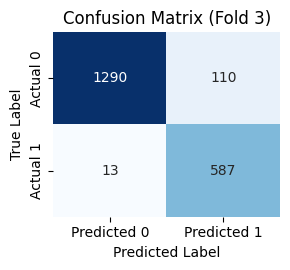

Epoch 17: 	Train Loss 0.006976 	Valid Loss 0.006244 	Valid AUROC 0.9897 	Valid AP 0.9713 	Valid F1 0.9052 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

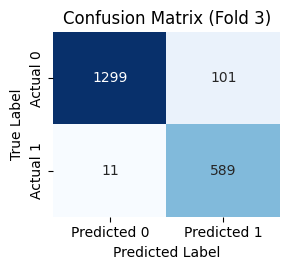

Epoch 18: 	Train Loss 0.006946 	Valid Loss 0.006464 	Valid AUROC 0.9915 	Valid AP 0.9757 	Valid F1 0.9132 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

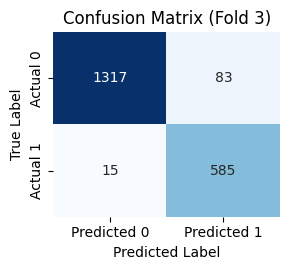

Epoch 19: 	Train Loss 0.007242 	Valid Loss 0.005659 	Valid AUROC 0.9916 	Valid AP 0.9763 	Valid F1 0.9227 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

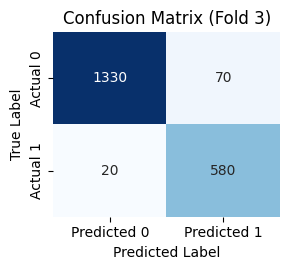

Epoch 20: 	Train Loss 0.007361 	Valid Loss 0.005564 	Valid AUROC 0.9906 	Valid AP 0.9717 	Valid F1 0.9280 	


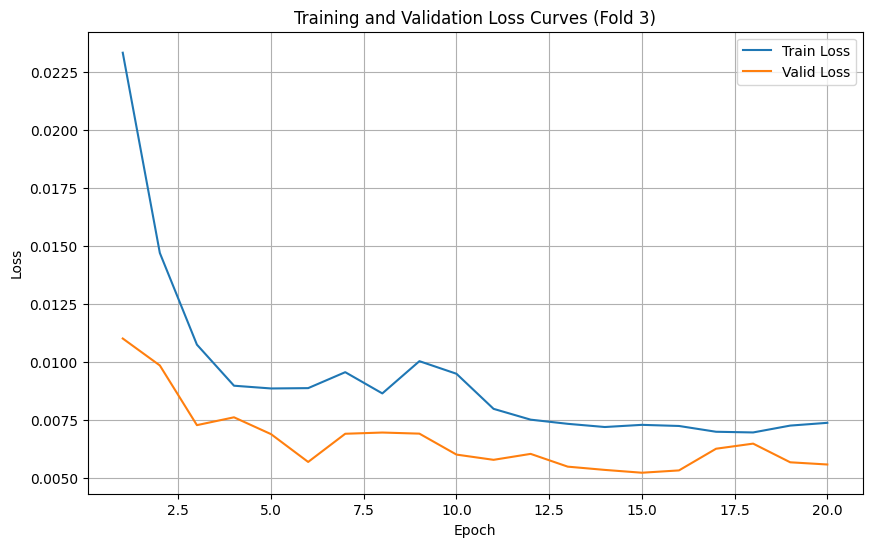

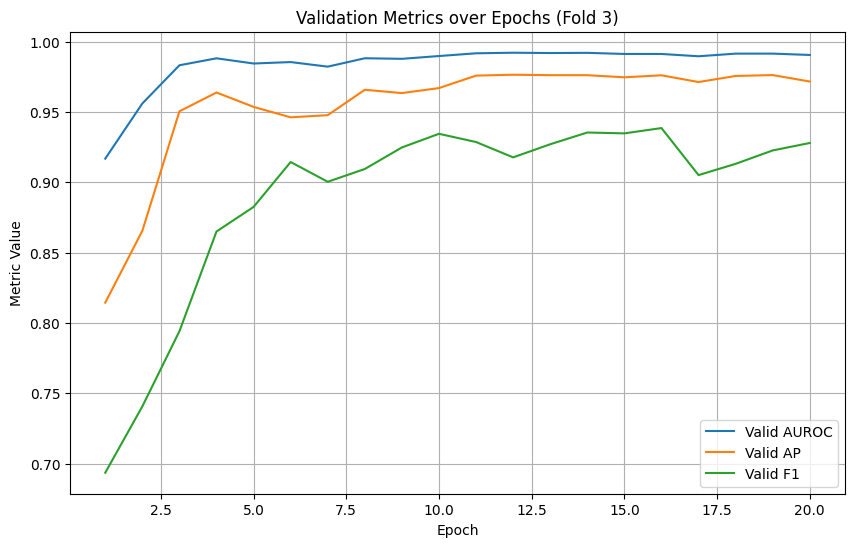


Fold 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

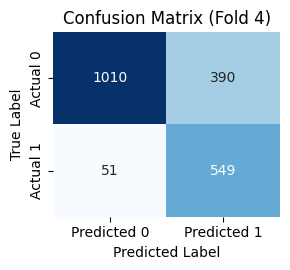

Epoch  1: 	Train Loss 0.023567 	Valid Loss 0.014957 	Valid AUROC 0.9074 	Valid AP 0.7937 	Valid F1 0.7135 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

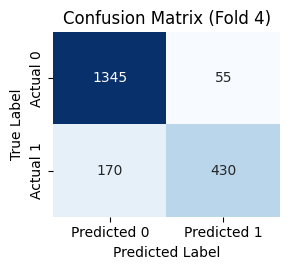

Epoch  2: 	Train Loss 0.013969 	Valid Loss 0.008154 	Valid AUROC 0.9624 	Valid AP 0.8936 	Valid F1 0.7926 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

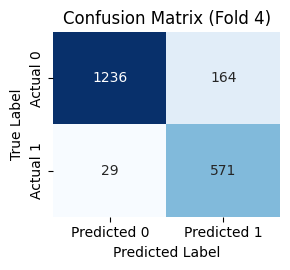

Epoch  3: 	Train Loss 0.010171 	Valid Loss 0.007866 	Valid AUROC 0.9738 	Valid AP 0.9337 	Valid F1 0.8554 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

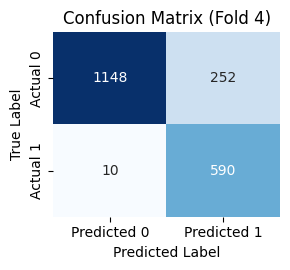

Epoch  4: 	Train Loss 0.009759 	Valid Loss 0.011116 	Valid AUROC 0.9792 	Valid AP 0.9540 	Valid F1 0.8183 	


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

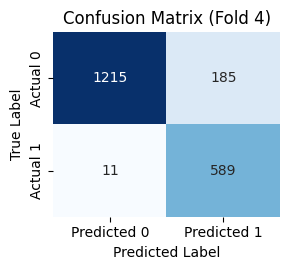

Epoch  5: 	Train Loss 0.008605 	Valid Loss 0.007820 	Valid AUROC 0.9874 	Valid AP 0.9666 	Valid F1 0.8574 	Best model for this fold -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

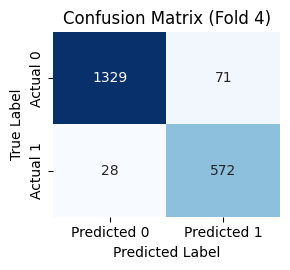

Epoch  6: 	Train Loss 0.009006 	Valid Loss 0.006215 	Valid AUROC 0.9859 	Valid AP 0.9615 	Valid F1 0.9204 	Best model for this fold -> saved


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

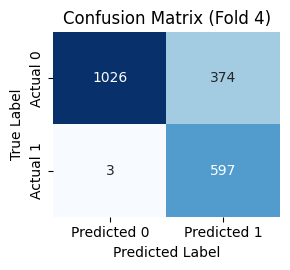

Epoch  7: 	Train Loss 0.008787 	Valid Loss 0.012924 	Valid AUROC 0.9835 	Valid AP 0.9633 	Valid F1 0.7600 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

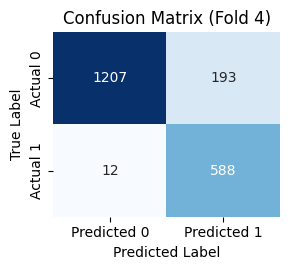

Epoch  8: 	Train Loss 0.009295 	Valid Loss 0.008732 	Valid AUROC 0.9840 	Valid AP 0.9662 	Valid F1 0.8516 	


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

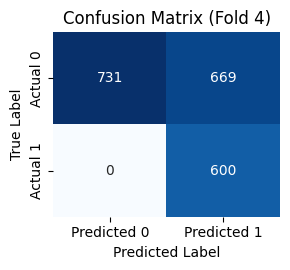

Epoch  9: 	Train Loss 0.009774 	Valid Loss 0.019267 	Valid AUROC 0.9859 	Valid AP 0.9665 	Valid F1 0.6421 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

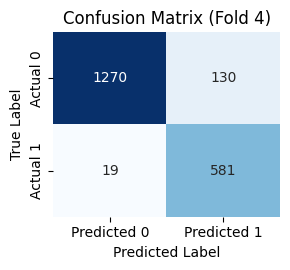

Epoch 10: 	Train Loss 0.009678 	Valid Loss 0.007693 	Valid AUROC 0.9829 	Valid AP 0.9578 	Valid F1 0.8863 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

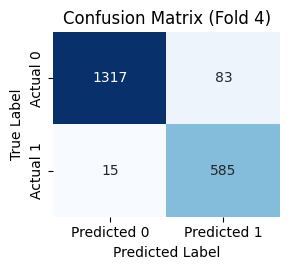

Epoch 11: 	Train Loss 0.008032 	Valid Loss 0.005763 	Valid AUROC 0.9927 	Valid AP 0.9833 	Valid F1 0.9227 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

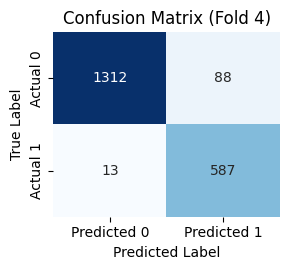

Epoch 12: 	Train Loss 0.007413 	Valid Loss 0.005735 	Valid AUROC 0.9928 	Valid AP 0.9844 	Valid F1 0.9208 	Best model for this fold -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

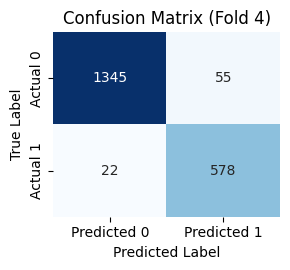

Epoch 13: 	Train Loss 0.007333 	Valid Loss 0.004996 	Valid AUROC 0.9926 	Valid AP 0.9837 	Valid F1 0.9376 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

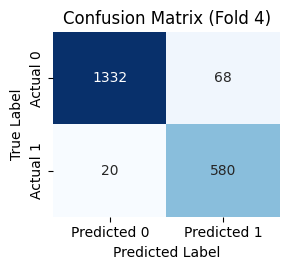

Epoch 14: 	Train Loss 0.007440 	Valid Loss 0.005430 	Valid AUROC 0.9935 	Valid AP 0.9859 	Valid F1 0.9295 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

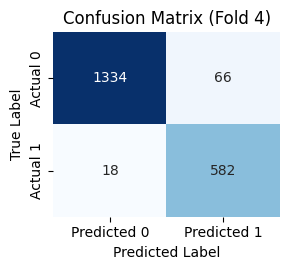

Epoch 15: 	Train Loss 0.007015 	Valid Loss 0.005259 	Valid AUROC 0.9932 	Valid AP 0.9838 	Valid F1 0.9327 	


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

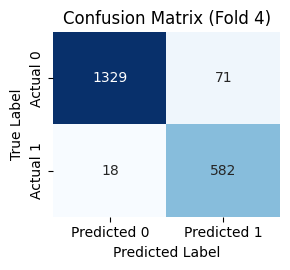

Epoch 16: 	Train Loss 0.007134 	Valid Loss 0.005505 	Valid AUROC 0.9934 	Valid AP 0.9852 	Valid F1 0.9290 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

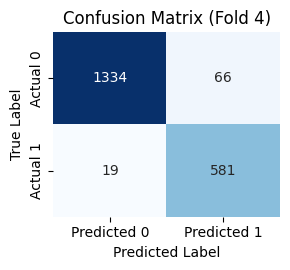

Epoch 17: 	Train Loss 0.007468 	Valid Loss 0.005565 	Valid AUROC 0.9922 	Valid AP 0.9821 	Valid F1 0.9318 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

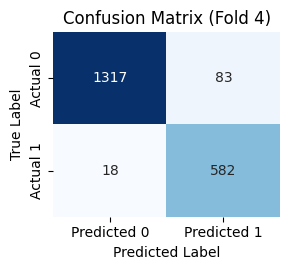

Epoch 18: 	Train Loss 0.007030 	Valid Loss 0.005595 	Valid AUROC 0.9925 	Valid AP 0.9825 	Valid F1 0.9202 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

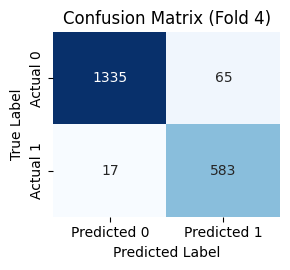

Epoch 19: 	Train Loss 0.007317 	Valid Loss 0.005273 	Valid AUROC 0.9927 	Valid AP 0.9849 	Valid F1 0.9343 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

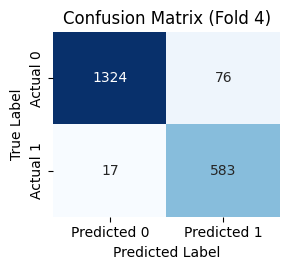

Epoch 20: 	Train Loss 0.006885 	Valid Loss 0.005611 	Valid AUROC 0.9924 	Valid AP 0.9818 	Valid F1 0.9261 	


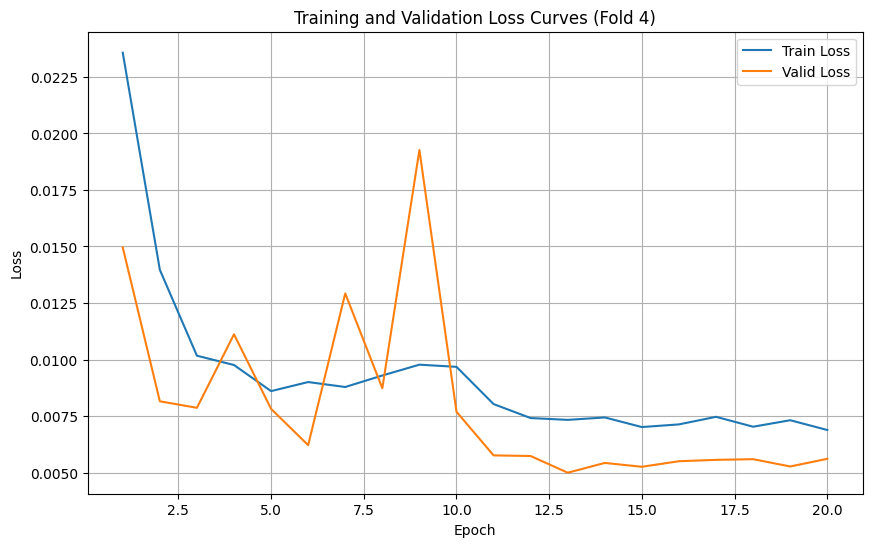

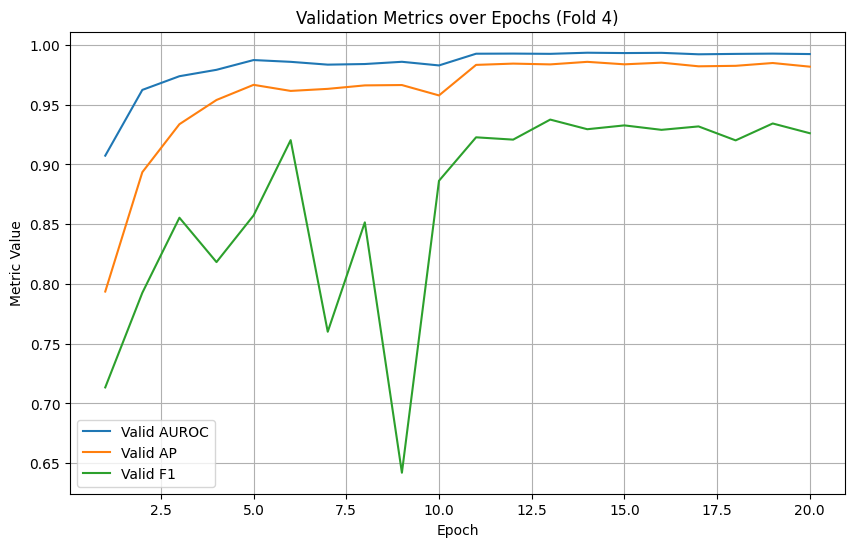


Fold 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

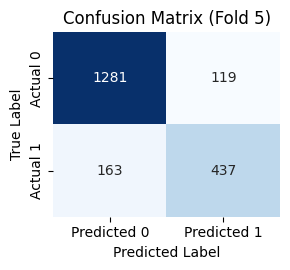

Epoch  1: 	Train Loss 0.022597 	Valid Loss 0.011064 	Valid AUROC 0.9227 	Valid AP 0.8273 	Valid F1 0.7561 	Best model for this fold -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

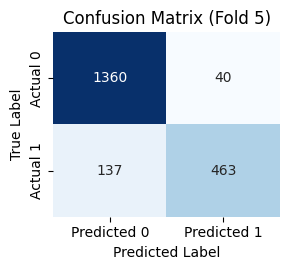

Epoch  2: 	Train Loss 0.013475 	Valid Loss 0.007277 	Valid AUROC 0.9676 	Valid AP 0.9335 	Valid F1 0.8395 	Best model for this fold -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

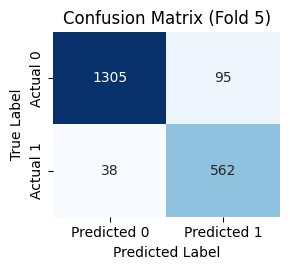

Epoch  3: 	Train Loss 0.010203 	Valid Loss 0.006083 	Valid AUROC 0.9783 	Valid AP 0.9473 	Valid F1 0.8942 	Best model for this fold -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

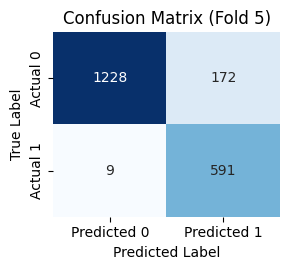

Epoch  4: 	Train Loss 0.008895 	Valid Loss 0.008250 	Valid AUROC 0.9812 	Valid AP 0.9469 	Valid F1 0.8672 	


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

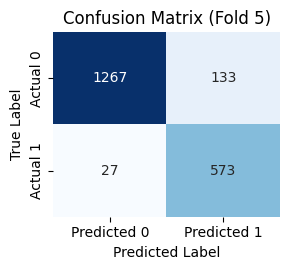

Epoch  5: 	Train Loss 0.008478 	Valid Loss 0.007536 	Valid AUROC 0.9782 	Valid AP 0.9442 	Valid F1 0.8775 	


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

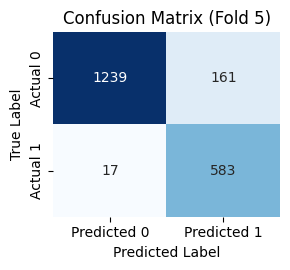

Epoch  6: 	Train Loss 0.008355 	Valid Loss 0.007576 	Valid AUROC 0.9844 	Valid AP 0.9643 	Valid F1 0.8676 	


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

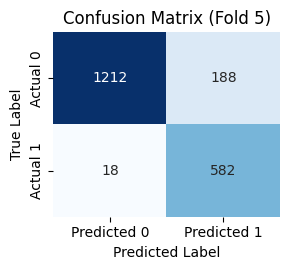

Epoch  7: 	Train Loss 0.008124 	Valid Loss 0.009153 	Valid AUROC 0.9753 	Valid AP 0.9485 	Valid F1 0.8496 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

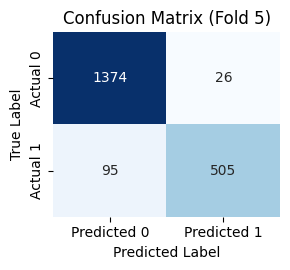

Epoch  8: 	Train Loss 0.009440 	Valid Loss 0.006150 	Valid AUROC 0.9852 	Valid AP 0.9701 	Valid F1 0.8930 	


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

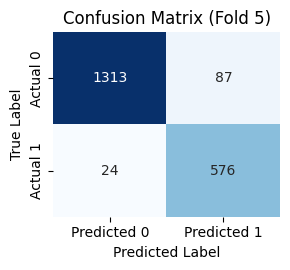

Epoch  9: 	Train Loss 0.009460 	Valid Loss 0.007306 	Valid AUROC 0.9788 	Valid AP 0.9444 	Valid F1 0.9121 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

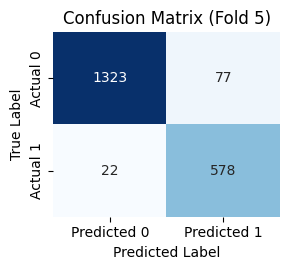

Epoch 10: 	Train Loss 0.009675 	Valid Loss 0.006702 	Valid AUROC 0.9876 	Valid AP 0.9727 	Valid F1 0.9211 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

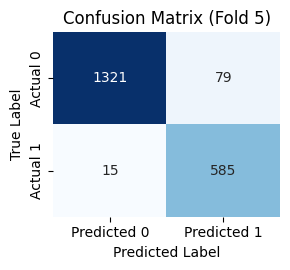

Epoch 11: 	Train Loss 0.007620 	Valid Loss 0.006063 	Valid AUROC 0.9906 	Valid AP 0.9774 	Valid F1 0.9256 	Best model for this fold -> saved


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

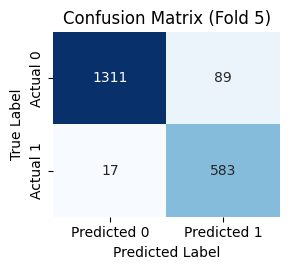

Epoch 12: 	Train Loss 0.007139 	Valid Loss 0.006131 	Valid AUROC 0.9902 	Valid AP 0.9771 	Valid F1 0.9167 	


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

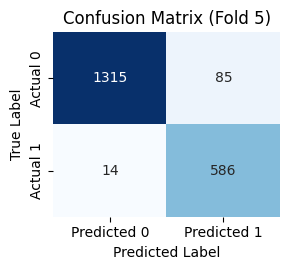

Epoch 13: 	Train Loss 0.007166 	Valid Loss 0.005811 	Valid AUROC 0.9910 	Valid AP 0.9784 	Valid F1 0.9221 	Best model for this fold -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

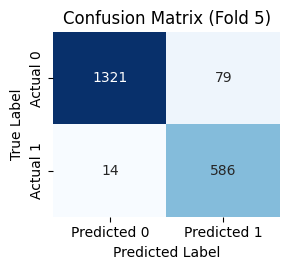

Epoch 14: 	Train Loss 0.007076 	Valid Loss 0.005731 	Valid AUROC 0.9901 	Valid AP 0.9789 	Valid F1 0.9265 	Best model for this fold -> saved


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

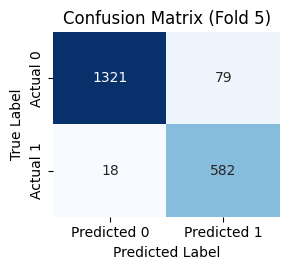

Epoch 15: 	Train Loss 0.007121 	Valid Loss 0.005640 	Valid AUROC 0.9901 	Valid AP 0.9785 	Valid F1 0.9231 	Best model for this fold -> saved


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

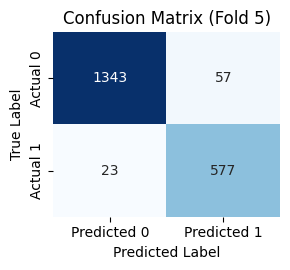

Epoch 16: 	Train Loss 0.006765 	Valid Loss 0.005086 	Valid AUROC 0.9911 	Valid AP 0.9791 	Valid F1 0.9352 	Best model for this fold -> saved


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

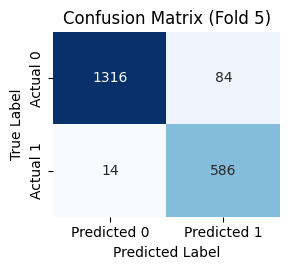

Epoch 17: 	Train Loss 0.007002 	Valid Loss 0.005630 	Valid AUROC 0.9915 	Valid AP 0.9783 	Valid F1 0.9228 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

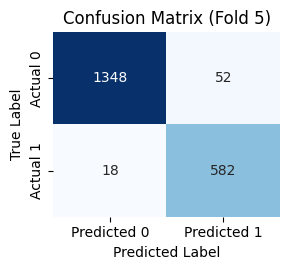

Epoch 18: 	Train Loss 0.006841 	Valid Loss 0.005211 	Valid AUROC 0.9902 	Valid AP 0.9769 	Valid F1 0.9433 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

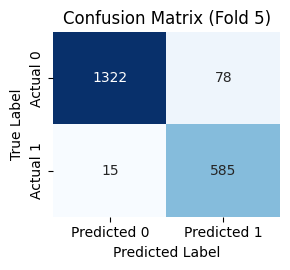

Epoch 19: 	Train Loss 0.006772 	Valid Loss 0.005558 	Valid AUROC 0.9907 	Valid AP 0.9773 	Valid F1 0.9264 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

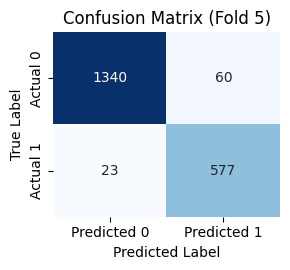

Epoch 20: 	Train Loss 0.006582 	Valid Loss 0.005229 	Valid AUROC 0.9898 	Valid AP 0.9747 	Valid F1 0.9329 	


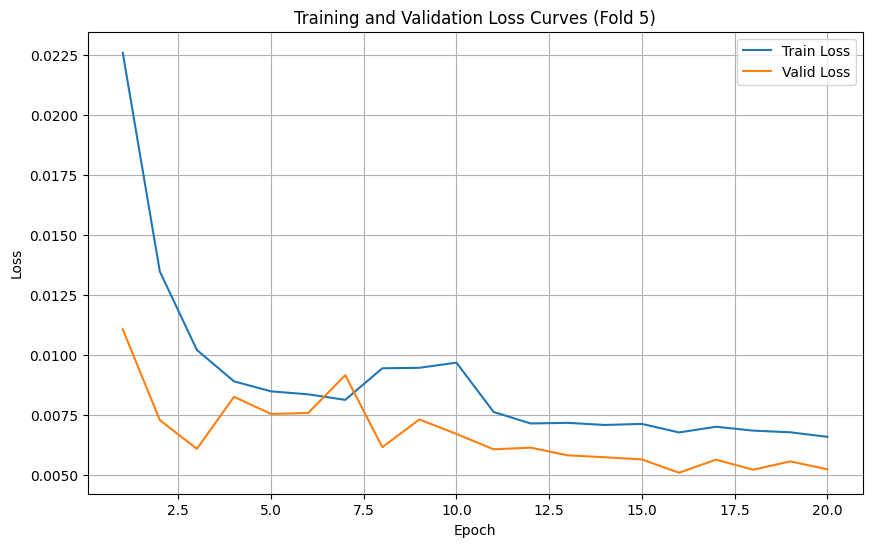

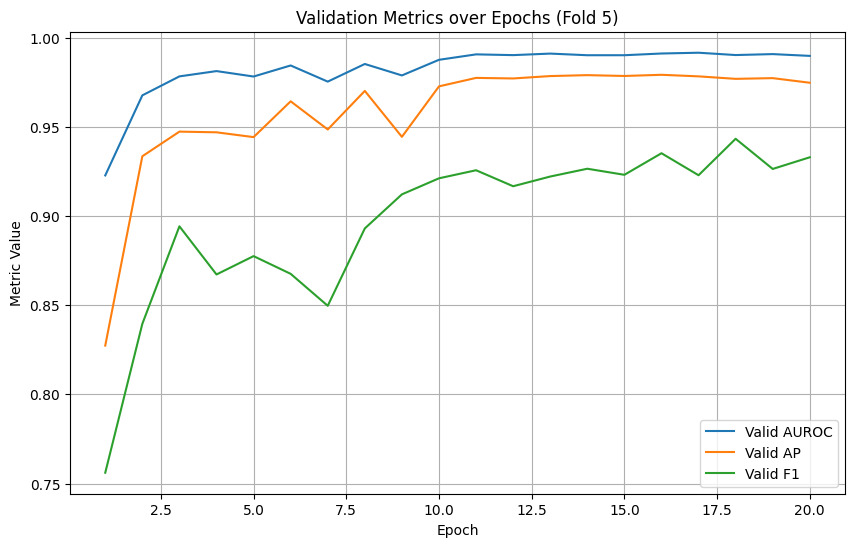

In [35]:
#added for stratified k-fold crossvalidation
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# confusion matrix
all_confusion_matrices = []
fold_results = []

# === Create output directory ===
os.makedirs("checkpoints", exist_ok=True)

# Define the number of folds
k_folds = 5

# Initialize StratifiedKFold
# We use labels.numpy().ravel() to get a 1D array of labels for stratification
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

# Lists to store metrics for each fold
fold_auroc_all, fold_ap_all, fold_f1_all = [], [], []

# Iterate through the folds
for fold, (train_idx, valid_idx) in enumerate(skf.split(dataset, labels.numpy().ravel())):
    tqdm.write(f"\nFold {fold+1}/{k_folds}")

    # Get the subsets for the current fold
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    valid_subset = torch.utils.data.Subset(dataset, valid_idx)

    # Calculate class weights for the current training subset for oversampling
    train_labels_fold = np.array([int(train_subset[i][1].item()) for i in range(len(train_subset))])
    class_weights_sampler_fold = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_fold), y=train_labels_fold)
    sample_weights_fold = [class_weights_sampler_fold[label] for label in train_labels_fold]
    sample_weights_fold = torch.tensor(sample_weights_fold, dtype=torch.float32)
    sampler_fold = WeightedRandomSampler(weights=sample_weights_fold, num_samples=len(sample_weights_fold), replacement=True)

    # Create DataLoaders for the current fold
    train_dataloader_fold = DataLoader(train_subset, batch_size=batch_size, sampler=sampler_fold)
    valid_dataloader_fold = DataLoader(valid_subset, batch_size=batch_size, shuffle=False) # No sampler for validation

    # Initialize a new model, optimizer, and scheduler for each fold
    model = CNNClassifier()
    # model = TransformerClassifier()
    # cnn = CNNClassifier()
    # model = CNNTransformerFusion(cnn_model=cnn, freeze_transformer=False)
    model.to(device=device)
    # Ensure class_weights_sampler_fold is used for weighted loss for the current fold
    loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights_sampler_fold[1], dtype=torch.float32).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    best_loss_fold = np.Inf
    train_loss_all_fold, valid_loss_all_fold = [], []
    valid_auroc_all_fold, valid_ap_all_fold, valid_f1_all_fold = [], [], []

    # Training and evaluation loop for the current fold
    for epoch in trange(1, num_epochs + 1):
        train_loss = train_loop(epoch, train_dataloader_fold, model, optimizer, loss_function, device)
        valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader_fold, model, nn.BCEWithLogitsLoss(), device) # Use standard loss for validation

        train_loss_all_fold.append(train_loss)
        valid_loss_all_fold.append(valid_loss)

        valid_auroc = roc_auc_score(y_true, y_pred)
        valid_ap = average_precision_score(y_true, y_pred)
        valid_f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

        # Convert predicted probabilities to binary predictions
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred_binary)

        # Plot confusion matrix
        plt.figure(figsize=(3, 2.8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix (Fold {fold+1})')
        plt.tight_layout()
        plt.show()

        all_confusion_matrices.append(cm)

        valid_auroc_all_fold.append(valid_auroc)
        valid_ap_all_fold.append(valid_ap)
        valid_f1_all_fold.append(valid_f1)

        if valid_loss < best_loss_fold:
            # Optionally save the best model for this fold
            torch.save({'model': model.state_dict()}, f'model_fold_{fold+1}.pth')

            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'valid_loss': valid_loss,
                        'valid_auroc': valid_auroc,
                        'valid_ap': valid_ap,
                        'valid_f1': valid_f1},
                       f'checkpoints/fold{fold}_best_model.pth')
            best_loss_fold = valid_loss
            model_save_state = "Best model for this fold -> saved"
        else:
            model_save_state = ""

        tqdm.write('Epoch {epoch:2d}: \t'
                    'Train Loss {train_loss:.6f} \t'
                    'Valid Loss {valid_loss:.6f} \t'
                    'Valid AUROC {valid_auroc:.4f} \t'
                    'Valid AP {valid_ap:.4f} \t'
                    'Valid F1 {valid_f1:.4f} \t'
                    '{model_save}'
                    .format(epoch=epoch,
                            train_loss=train_loss,
                            valid_loss=valid_loss,
                            valid_auroc=valid_auroc,
                            valid_ap=valid_ap,
                            valid_f1=valid_f1,
                            model_save=model_save_state)
                        )

        if lr_scheduler:
            lr_scheduler.step()

    # Store the best metrics from this fold
    best_epoch_idx = np.argmin(valid_loss_all_fold)
    fold_auroc_all.append(valid_auroc_all_fold[best_epoch_idx])
    fold_ap_all.append(valid_ap_all_fold[best_epoch_idx])
    fold_f1_all.append(valid_f1_all_fold[best_epoch_idx])

    # Plot learning curves for the current fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_loss_all_fold, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_loss_all_fold, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves (Fold {fold+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot validation metrics for the current fold
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), valid_auroc_all_fold, label='Valid AUROC')
    plt.plot(range(1, num_epochs + 1), valid_ap_all_fold, label='Valid AP')
    plt.plot(range(1, num_epochs + 1), valid_f1_all_fold, label='Valid F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title(f'Validation Metrics over Epochs (Fold {fold+1})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 🔖 NEW: Save per-fold results to memory
fold_result = {
    'fold': fold,
    'best_epoch': int(best_epoch_idx + 1),
    'best_valid_loss': float(valid_loss_all_fold[best_epoch_idx]),
    'best_valid_auroc': float(valid_auroc_all_fold[best_epoch_idx]),
    'best_valid_ap': float(valid_ap_all_fold[best_epoch_idx]),
    'best_valid_f1': float(valid_f1_all_fold[best_epoch_idx]),
}
fold_results.append(fold_result)

# 🔖 NEW: Save to individual JSON
with open(f'metrics/fold{fold}_metrics.json', 'w') as f:
    json.dump(fold_result, f, indent=2)


In [42]:
# 🔖 NEW: Save summary of all fold metrics
with open('metrics/all_folds_metrics.json', 'w') as f:
    json.dump(fold_results, f, indent=2)

# 🔖 NEW: Print average metrics
mean_auroc = sum([f['best_valid_auroc'] for f in fold_results])
mean_ap = sum([f['best_valid_ap'] for f in fold_results])
mean_f1 = sum([f['best_valid_f1'] for f in fold_results])

print("\n🔍 Cross-validation summary:")
print(f"Mean AUROC: {mean_auroc:.4f}")
print(f"Mean AP:    {mean_ap:.4f}")
print(f"Mean F1:    {mean_f1:.4f}")


🔍 Cross-validation summary:
Mean AUROC: 0.9911
Mean AP:    0.9791
Mean F1:    0.9352


In [37]:
# Examine the stored metrics for each fold
print("Performance metrics for each fold:")
for i, (auroc, ap, f1) in enumerate(zip(fold_auroc_all, fold_ap_all, fold_f1_all)):
    print(f"Fold {i+1}: AUROC={auroc:.4f}, AP={ap:.4f}, F1={f1:.4f}")

# Find the index of the best performing fold based on F1 score
best_fold_index = np.argmax(fold_f1_all)
best_f1_score = fold_f1_all[best_fold_index]
best_auroc_score = fold_auroc_all[best_fold_index]
best_ap_score = fold_ap_all[best_fold_index]

print(f"\nBest performing fold based on F1 score: Fold {best_fold_index + 1}")
print(f"Best F1 Score: {best_f1_score:.4f}")
print(f"Corresponding AUROC: {best_auroc_score:.4f}")
print(f"Corresponding AP: {best_ap_score:.4f}")

Performance metrics for each fold:
Fold 1: AUROC=0.9907, AP=0.9776, F1=0.9317
Fold 2: AUROC=0.9873, AP=0.9681, F1=0.9273
Fold 3: AUROC=0.9913, AP=0.9747, F1=0.9348
Fold 4: AUROC=0.9926, AP=0.9837, F1=0.9376
Fold 5: AUROC=0.9911, AP=0.9791, F1=0.9352

Best performing fold based on F1 score: Fold 4
Best F1 Score: 0.9376
Corresponding AUROC: 0.9926
Corresponding AP: 0.9837


---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain soft predictions (probabilities) instead of hard predictions (0s or 1s).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The predictions are saved in the variable `soft_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [43]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [44]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
# model = ModelBaseline()
model = CNNClassifier()

# load stored model parameters from the best performing fold (Fold 5)
# The best fold index is stored in `best_fold_index` from the previous cell
# ckpt = torch.load(f'model.pth', map_location=lambda storage, loc: storage)
# ckpt = torch.load(f'model_hybrid.pth', map_location=lambda storage, loc: storage)
ckpt = torch.load(f'model_fold_{best_fold_index + 1}.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

In [2]:
from glob import glob

# Load data
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load all best models
model_paths = sorted(glob("checkpoints/fold*_best_model.pth"))
ensemble_models = []

for path in model_paths:
    model = CNNClassifier().to(device)
    ckpt = torch.load(path, map_location=lambda storage, loc: storage)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    ensemble_models.append(model)

# Predict with ensemble
test_pred_all_models = torch.zeros((len(dataset), len(ensemble_models)))
end = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Ensemble Testing"):
        traces_batch = batch[0].to(device)
        batch_size = traces_batch.shape[0]
        ensemble_logits = torch.zeros((batch_size, len(ensemble_models)), device=device)

        for i, model in enumerate(ensemble_models):
            logits = model(traces_batch)
            probs = torch.sigmoid(logits).squeeze()
            ensemble_logits[:, i] = probs

        averaged_probs = ensemble_logits.mean(dim=1).cpu()
        start = end
        end = start + batch_size
        test_pred_all_models[start:end, :] = ensemble_logits.cpu()

# Average across all models
test_pred_mean = test_pred_all_models.mean(dim=1, keepdim=True)
soft_pred = np.stack((1 - test_pred_mean.numpy(), test_pred_mean.numpy()), axis=1).squeeze()
np.save('ensemble_soft_preds.npy', soft_pred)

NameError: name 'torch' is not defined

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [45]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [46]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = 'LundBooster' #Fill in a string
password = 'LundBooster' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [47]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'MonsterHigh' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


In [47]:
len(note)

11

### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|Classifier-Gnarly| 0.946 | 0.946 | 0.985| 0.984 | Add data augumentation and increased learning rate from 1e-4 to 1e-3	|
|Classifier-Comeback| 0.928| 0.924| 0.981| 0.981| Add 10-fold stratified cross validation|
|Classifier-Debut| 0.751 | 0.682 | 0.933| 0.927| not enough epoches, accidentally submitted the model trained only 1 epoch |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**